In [2]:
import os
import time
import sys
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# helper method to define model
def deepnn(x):
    x_image = tf.reshape(x, [-1, 32, 32, 3])
#     x_image = tf.image.resize_image_with_crop_or_pad(x_image, target_height=32, target_width=32)

    W_conv1 = weight_variable([5, 5, 3, 6])
    b_conv1 = bias_variable([6])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    h_pool1 = max_pool_2x2(h_conv1)

    W_conv2 = weight_variable([5, 5, 6, 16])
    b_conv2 = bias_variable([16])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    h_pool2 = max_pool_2x2(h_conv2)

    W_conv3 = weight_variable([5, 5, 16, 10])
    b_conv3 = bias_variable([10])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    
    h_pool3 = max_pool_2x2(h_conv3)
    
    gap_1 = tf.nn.avg_pool(h_pool3, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
    
    dense = tf.reshape(gap_1, [-1, 10])
    
    dense = tf.reshape(dense, [-1, 10])
    return x_image, dense, h_conv1, h_pool1, h_conv2, h_pool2, h_conv3, h_pool3, gap_1

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [4]:
#load graph and data and run training

tf.reset_default_graph()

# reading data
# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# defining TF model
x = tf.placeholder(tf.float32, [None, 3072])
y_ = tf.placeholder(tf.float32, [None, 10])
x_image, y_conv, h_conv1, h_pool1, h_conv2, h_pool2, h_conv3, h_pool3, gap_1 = deepnn(x)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_conv, labels = y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# trainning CNN
sess= tf.Session()
saver = tf.train.Saver()
saver.restore(sess, './cifar_model/model_chkpt-19990')
# sess.run(tf.global_variables_initializer())
# with sess.as_default():
#     for i in range(10000):
#         batch = mnist.train.next_batch(50)
#         if i%10 == 0:
#             train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1]})
#             print("step %d, training accuracy %g"%(i, train_accuracy))
#         train_step.run(feed_dict={x: batch[0], y_: batch[1]})
        
#     x_feed = mnist.test.images.reshape(-1, 784)[:100]
#     y_feed = mnist.test.labels.reshape(-1, 10)[:100]
#     print("test accuracy %g"%accuracy.eval(feed_dict={x: x_feed, y_: y_feed, 
#                                                       }))

#     test_x = mnist.test.images.reshape(-1, 784)[0]
#     test_y = mnist.test.images.reshape(-1, 10)[0]
#     feed_dict = {x: test_x, y:test_y}

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

INFO:tensorflow:Restoring parameters from ./cifar_model/model_chkpt-19990


In [5]:
filename = './cifar/tfrecords/eval.tfrecords/'
record_iterator = tf.python_io.tf_record_iterator(filename)
serialized_img_example = next(record_iterator)

In [13]:
serialized_img_example = next(record_iterator)

In [14]:
example = tf.train.Example()
example.ParseFromString(serialized_img_example)
image = example.features.feature['image'].bytes_list.value
label = example.features.feature['label'].int64_list.value[0]

In [15]:
img_flat = np.fromstring(image[0], dtype = np.uint8)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """Entry point for launching an IPython kernel.


In [16]:
label

8L

In [17]:
def forwardprop(sess, image):
    image = image.reshape(-1, 3072)
    output = sess.run(y_conv, feed_dict={x:image})
    return output

In [18]:
output = forwardprop(sess, img_flat)

In [19]:
output

array([[1144.0492  , 1146.6886  ,  289.53836 ,  516.0735  ,  370.65097 ,
         438.8015  ,   14.925794,  576.9211  , 1662.8628  , 1203.683   ]],
      dtype=float32)

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
img = img_flat.reshape(32, 32, -1)

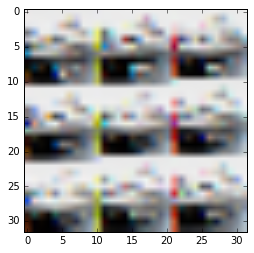

In [33]:
plt.imshow(img)

In [34]:
label = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [42]:
def create_adv_image(x_image, y_label, lr=0.01, n_steps=17):
    
    original_image = x_image
    
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv)
    deriv = tf.gradients(loss, x)
    image_adv = tf.stop_gradient(x - tf.sign(deriv)*lr)
    image_adv = tf.clip_by_value(image_adv, 0, 1)
    
    for _ in range(n_steps):
        dydx = sess.run(deriv, {x:x_image.reshape(-1, 3072)})
        
        x_adv = sess.run(image_adv, {x: x_image.reshape(-1, 3072)})
        
        x_image = np.reshape(x_adv, (1, 3072))
        
    return x_image

In [43]:
adv = create_adv_image(img_flat, label, n_steps=12)

In [44]:
op = forwardprop(sess, adv)

In [45]:
op

array([[7.577426 , 3.2151368, 4.286089 , 5.018964 , 1.5352731, 5.045824 ,
        0.6271415, 1.552331 , 7.4308033, 1.5626346]], dtype=float32)

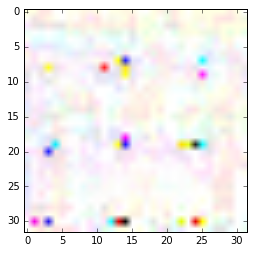

In [46]:
plt.imshow(adv.reshape(32, 32, 3))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(adv.reshape((32, 32)), cmap='jet')

fig.colorbar(im, ax=ax)

# plt.imshow(adv.reshape((28, 28)))
plt.savefig('adversarial_1_output_0')

In [ ]:
adv = adv.reshape((784, ))

In [ ]:
diff = adv - test_x

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(diff.reshape((28, 28)), cmap='jet')

fig.colorbar(im, ax=ax)

# plt.imshow(diff.reshape((28, 28)))
plt.savefig('./difference_image')

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(test_x.reshape((28, 28)), cmap='jet')

fig.colorbar(im, ax=ax)

# plt.imshow(diff.reshape((28, 28)))
plt.savefig('./actual_image')

In [ ]:
saver = tf.train.Saver()

saver.save(sess, './adversarial_example')